<a href="https://colab.research.google.com/github/dolmarawat/Studentdefaultrisk/blob/main/KDDM_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
# sklearn data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
# sklearn decision trees
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
# tree visualizer
from sklearn import tree
# for variable importance
from sklearn.ensemble import RandomForestClassifier
# sklearn metrics
from sklearn.metrics import (f1_score, roc_curve, precision_recall_curve,
auc, make_scorer, recall_score, accuracy_score,
precision_score, confusion_matrix)
# data visualization
import matplotlib.pyplot as plt
%matplotlib inline
# cluster visualizer
from yellowbrick.cluster import KElbowVisualizer
import warnings
warnings.filterwarnings("ignore")
np.warnings = warnings

# LOAD DATASET

In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# prompt: get the data from this folder "Group Project(KDDM"

import pandas as pd
import os

# Assuming the folder is in your Google Drive
file_path = "/content/drive/My Drive/Group Project(KDDM)"

# List all files in the folder
file_list = os.listdir(file_path)

for files in file_list:
  print(files)


enlist.pl
unemployed.pl
Region, Marital Status.xlsx
DS_Store
Personality Characteristics Data.xlsx
Parents_Education.xlsx
no_payment_due.pl
enrolled.pl
Family_Income .xlsx
filed_for_bankrupcy.pl
HS_Academics 2012 .xlsx
LoanAmount.xlsx
longest_absense_from_school (1).pl
male .pl
CreditRating Data 2012.xlsx
merged_data_final.xlsx
merged_data.xlsx
merged_data_student_id.xlsx
Group Project(KDDM) 
score35.xlsx


# Read the dataset

In [ ]:
def dataframe_conv(file_name):
    df = pd.read_excel(file_path + '/' + file_name)
    print(df.head())
    return df

In [ ]:

df_region_marital = dataframe_conv('Region, Marital Status.xlsx')

   STUDENT_ID Country  Region  Married
0           1     USA       2        1
1           2     USA       5        0
2           3     USA       2        1
3           4     USA       1        0
4           5     USA       3        0


In [ ]:
df_personality_char = dataframe_conv('Personality Characteristics Data.xlsx')


   STUDENT_ID  LongTermPlannerScore  DecisionStyle  PowerOrientedScore  \
0           1               0.956004     Emotional            0.767967   
1           2               0.601589    Analytical            1.000000   
2           3               0.655254     Emotional            0.589539   
3           4               0.841278     Emotional            0.805702   
4           5               0.738851     Emotional            0.415433   

   CommunityOrientedScore  
0                0.189491  
1                0.529815  
2                0.589539  
3                0.061538  
4                0.241257  


In [ ]:
df_parents_edu = dataframe_conv('Parents_Education.xlsx')

   STUDENT_ID PARENTS_EDUCATION_LEVEL
0           1              Bachelor's
1           2               Doctorate
2           3             HS or Lower
3           4                Master's
4           5                Master's


In [ ]:
df_family_income = dataframe_conv('Family_Income .xlsx')

   STUDENT_ID  Family_Income
0           1      109770.95
1           2       58442.99
2           3       97125.87
3           4       55256.40
4           5       58187.16


In [ ]:
df_hs_acad = dataframe_conv('HS_Academics 2012 .xlsx')

   STUDENT_ID  HS_Math  HS_Science  HS_English
0           1       10          10        10.0
1           2        9           9        10.0
2           3        9           6         6.0
3           4       10           9         9.0
4           5        6           8         5.0


In [ ]:
df_loanamount = dataframe_conv('LoanAmount.xlsx')

   STUDENT_ID  Loan_Amount
0           1        19861
1           2        17391
2           3         8118
3           4        18905
4           5        16175


In [ ]:
df_credit_rating = dataframe_conv('CreditRating Data 2012.xlsx')


   STUDENT_ID  Credit_Score_Raw  Credit_Score_AgeAdj
0           1          0.495227             0.767967
1           2          0.987649             0.529815
2           3          0.249315             0.589539
3           4          0.653183             0.805702
4           5          0.273099             0.415433


In [ ]:
import re
def parse_prolog_file(file_name):
    """
    Parses a .pl Prolog-like file and returns a DataFrame with:
    - Function (e.g., 'enlist', 'no_payment_due')
    - StudentNumber (e.g., 1000)
    - Label (e.g., 'fire_department', 'pos', 'neg')
    """
    pattern = r'(\w+)\(student(\d+),(\w+)\)\.'

    parsed_data = []
    with open(file_path + '/'+ file_name, "r") as f:
        for line in f:
            match = re.match(pattern, line.strip())
            if match:
                function_name = match.group(1)
                student_number = int(match.group(2))
                label = match.group(3)
                parsed_data.append((student_number, label))

    return pd.DataFrame(parsed_data, columns=["STUDENT_ID", function_name])

In [ ]:
def parse_prolog_file_auto(file_name, column_names):
    """
    Parses .pl file with 1, 2, or 3 arguments like:
        one arg: unemployed(student123).
        two args: enlist(student123, fire_department).
        three args: score(student123, math, 95).

    Args:
        file_path (str): path to the .pl file
        column_names (list): column names to assign after StudentID

    Returns:
        pd.DataFrame: parsed data with column headers
    """
    parsed_data = []

    with open(file_path + '/'+ file_name, "r") as f:
        for line in f:
            line = line.strip().rstrip('.')
            match = re.match(r'\w+\((.*?)\)', line)
            if match:
                parts = [p.strip() for p in match.group(1).split(',')]
                if parts[0].startswith("student"):
                    student_id = int(parts[0].replace("student", ""))
                    rest = parts[1:]
                else:
                    continue  # skip malformed line

                row = [student_id] + rest
                parsed_data.append(row)

    return pd.DataFrame(parsed_data, columns=["STUDENT_ID"] + column_names)

In [ ]:
df_enlist = parse_prolog_file_auto("enlist.pl", ['service'])
df_enlist['Enlisted'] = 1
df_enlist.head()

STUDENT_ID          service  Enlisted
0          40  fire_department         1
1          51  fire_department         1
2         109  fire_department         1
3         139  fire_department         1
4         148  fire_department         1

In [ ]:
df_no_payment = parse_prolog_file_auto("no_payment_due.pl", ["no_payement_due"])
df_no_payment.head()

STUDENT_ID no_payement_due
0        1000             pos
1         999             pos
2         998             pos
3         996             pos
4         994             pos

In [ ]:
df_enrolled = parse_prolog_file_auto("enrolled.pl", ["School", "Units"])
df_enrolled.head()


STUDENT_ID School Units
0          10    ucb     2
1          18   ucsd     4
2          20   ucsd     3
3          35   ucsd     4
4          44   ucsd     1

In [ ]:
df_longest_absense_from_school_1 = parse_prolog_file_auto("longest_absense_from_school (1).pl", ["Months"])
df_longest_absense_from_school_1.head()

STUDENT_ID Months
0        1000      7
1         999      4
2         998      1
3         997      8
4         996      7

In [ ]:
import pandas as pd
import re

def parse_single_column_pl(file_name, column_name):
    """
    Parses Prolog-style .pl files with one student ID per line.
    Example: male(student997).

    Args:
        file_path (str): file name (e.g., 'male.pl')
        column_name (str): name of the binary column (e.g., 'Male')

    Returns:
        DataFrame with columns ['StudentID', column_name]
    """
    pattern = r'\w+\((student\d+)\)\.'  # matches student997 inside parentheses
    parsed_rows = []

    with open(file_path + '/'+ file_name, "r") as f:
        for line in f:
            match = re.match(pattern, line.strip())
            if match:
                student_id = int(match.group(1).replace("student", ""))
                parsed_rows.append((student_id, 1))

    return pd.DataFrame(parsed_rows, columns=['STUDENT_ID', column_name])


In [ ]:
df_male = parse_single_column_pl("male .pl", "Male")
df_male.head()

STUDENT_ID  Male
0         997     1
1         994     1
2         992     1
3         987     1
4         986     1

In [ ]:
df_unemployed= parse_single_column_pl("unemployed.pl", "unemployed")
df_unemployed.head()

STUDENT_ID  unemployed
0        1000           1
1         996           1
2         993           1
3         948           1
4         946           1

In [ ]:
# STEP 1: Create base reference list of student IDs from df_no_payment
all_students = pd.DataFrame({'STUDENT_ID': df_no_payment['STUDENT_ID'].unique()})
all_students['STUDENT_ID'] = all_students['STUDENT_ID'].astype(int)

# STEP 2: Define a list of all your other datasets to merge
dataframes_to_merge = [
    df_enlist, df_enrolled, df_unemployed, df_male, df_region_marital,
    df_personality_char, df_parents_edu, df_family_income, df_hs_acad,
    df_loanamount, df_credit_rating, df_longest_absense_from_school_1
]

# STEP 3: Normalize all StudentID columns to int
for df in dataframes_to_merge:
    df['STUDENT_ID'] = df['STUDENT_ID'].astype(int)

# STEP 4: Merge all into one master dataset using left join
merged_df = all_students.copy()
for df in dataframes_to_merge:
    merged_df = pd.merge(merged_df, df, on="STUDENT_ID", how="left")

# STEP 5: Add back target column (e.g., NoPaymentDue)
df_no_payment['STUDENT_ID'] = df_no_payment['STUDENT_ID'].astype(int)
merged_df = pd.merge(merged_df, df_no_payment, on="STUDENT_ID", how="left")

# STEP 6: Final check
print("Final shape:", merged_df.shape)
merged_df.head(100)


Final shape: (1260, 24)


STUDENT_ID          service  Enlisted School Units  unemployed  Male  \
0         1000        air_force       1.0   ucsd     5         1.0   NaN   
1         1000        air_force       1.0    occ     9         1.0   NaN   
2          999  fire_department       1.0    smc     4         NaN   NaN   
3          998              NaN       NaN    ucb     1         NaN   NaN   
4          998              NaN       NaN    smc     1         NaN   NaN   
5          996             navy       1.0    smc    11         1.0   NaN   
6          994              NaN       NaN    uci     9         NaN   1.0   
7          993  fire_department       1.0    ucb     6         1.0   NaN   
8          992          marines       1.0   ucsd     1         NaN   1.0   
9          992          marines       1.0    smc    11         NaN   1.0   
10         990              NaN       NaN    smc    10         NaN   NaN   
11         989              NaN       NaN   ucla    12         NaN   NaN   
12         987              NaN       NaN    occ    12         NaN   1.0   
13         985  fire_department       1.0   ucla     1         NaN   NaN   
14         985             navy       1.0   ucla     1         NaN   NaN   
15         984              NaN       NaN   ucsd     3         NaN   1.0   
16         984              NaN       NaN    smc     8         NaN   1.0   
17         983              NaN       NaN   ucsd     5         NaN   1.0   
18         983              NaN       NaN   ucla    13         NaN   1.0   
19         981        air_force       1.0    occ    10         NaN   1.0   
20         977   foreign_legion       1.0    uci    11         NaN   1.0   
21         976              NaN       NaN    occ    11         NaN   1.0   
22         975             army       1.0   ucsd     4         NaN   1.0   
23         975             army       1.0    occ     2         NaN   1.0   
24         972              NaN       NaN    uci    10         NaN   1.0   
25         970              NaN       NaN   ucla    10         NaN   NaN   
26         969              NaN       NaN    ucb     1         NaN   NaN   
27         969              NaN       NaN    uci     8         NaN   NaN   
28         968              NaN       NaN    smc    12         NaN   NaN   
29         967              NaN       NaN    uci    12         NaN   NaN   
30         963              NaN       NaN    uci    11         NaN   NaN   
31         962          marines       1.0   ucla    10         NaN   1.0   
32         959        air_force       1.0    ucb     3         NaN   NaN   
33         959        air_force       1.0   ucla    12         NaN   NaN   
34         958              NaN       NaN    smc     6         NaN   1.0   
35         956             army       1.0    uci     5         NaN   NaN   
36         955          marines       1.0    uci    12         NaN   NaN   
37         953              NaN       NaN   ucsd     1         NaN   1.0   
38         953              NaN       NaN    uci     7         NaN   1.0   
39         952             navy       1.0    uci     2         NaN   1.0   
40         950              NaN       NaN    smc     7         NaN   1.0   
41         949              NaN       NaN   ucla    12         NaN   NaN   
42         948        air_force       1.0   ucsd     3         1.0   1.0   
43         948        air_force       1.0    occ     1         1.0   1.0   
44         947              NaN       NaN    smc     9         NaN   1.0   
45         946             navy       1.0   ucsd     6         1.0   NaN   
46         946             navy       1.0    uci     1         1.0   NaN   
47         945              NaN       NaN    uci    12         NaN   NaN   
48         943              NaN       NaN    occ     7         NaN   1.0   
49         942        air_force       1.0    ucb     3         NaN   NaN   
50         942        air_force       1.0    uci     4         NaN   NaN   
51         940              NaN       NaN   ucla    

In [ ]:
merged_df["STUDENT_ID"].value_counts().loc[lambda x: x > 1]


STUDENT_ID
161     4
876     4
233     4
1000    2
35      2
983     2
18      2
10      2
131     2
953     2
948     2
946     2
942     2
985     2
87      2
111     2
101     2
107     2
186     2
160     2
245     2
240     2
927     2
924     2
923     2
959     2
221     2
218     2
289     2
984     2
299     2
298     2
290     2
363     2
348     2
343     2
413     2
895     2
890     2
888     2
936     2
379     2
374     2
457     2
501     2
487     2
463     2
535     2
532     2
528     2
525     2
518     2
514     2
513     2
574     2
571     2
864     2
863     2
858     2
854     2
564     2
20      2
552     2
551     2
604     2
623     2
726     2
722     2
791     2
675     2
840     2
838     2
836     2
835     2
832     2
825     2
879     2
842     2
777     2
737     2
829     2
822     2
816     2
810     2
796     2
812     2
798     2
850     2
860     2
851     2
845     2
844     2
839     2
871     2
900     2
938     2
931     2
925     2
919     2
982     2
978     2
787     2
785     2
778     2
961     2
960     2
954     2
8       2
6       2
995     2
991     2
41      2
32      2
31      2
28      2
21      2
17      2
64      2
753     2
792     2
62      2
59      2
52      2
51      2
43      2
268     2
91      2
90      2
69      2
75      2
109     2
104     2
95      2
68      2
740     2
738     2
735     2
773     2
769     2
130     2
122     2
744     2
154     2
150     2
147     2
142     2
139     2
179     2
169     2
168     2
162     2
714     2
710     2
702     2
698     2
193     2
189     2
120     2
227     2
225     2
214     2
224     2
255     2
253     2
250     2
213     2
682     2
680     2
723     2
678     2
242     2
241     2
232     2
280     2
279     2
275     2
271     2
267     2
263     2
304     2
301     2
658     2
690     2
316     2
314     2
313     2
309     2
308     2
350     2
349     2
340     2
339     2
382     2
370     2
369     2
367     2
359     2
634     2
629     2
670     2
403     2
399     2
396     2
391     2
385     2
421     2
415     2
411     2
450     2
441     2
440     2
481     2
472     2
470     2
458     2
505     2
502     2
619     2
615     2
612     2
609     2
650     2
500     2
498     2
497     2
486     2
533     2
530     2
523     2
562     2
598     2
595     2
590     2
624     2
555     2
539     2
538     2
584     2
583     2
578     2
576     2
568     2
606     2
605     2
602     2
998     2
975     2
969     2
47      2
44      2
78      2
60      2
53      2
992     2
Name: count, dtype: int64

In [ ]:
merged_df[merged_df['STUDENT_ID'] == 777]


STUDENT_ID service  Enlisted School Units  unemployed  Male Country  \
936         777     NaN       NaN    ucb     4         NaN   NaN     USA   
937         777     NaN       NaN    occ     2         NaN   NaN     USA   

     Region  Married  LongTermPlannerScore  DecisionStyle  PowerOrientedScore  \
936       2        0               0.517411     Emotional            0.438828   
937       2        0               0.517411     Emotional            0.438828   

     CommunityOrientedScore PARENTS_EDUCATION_LEVEL  Family_Income  HS_Math  \
936                 0.05384                Master's       98302.02       10   
937                 0.05384                Master's       98302.02       10   

     HS_Science  HS_English  Loan_Amount  Credit_Score_Raw  \
936           9         8.0        19834          0.131877   
937           9         8.0        19834          0.131877   

     Credit_Score_AgeAdj Months no_payement_due  
936             0.438828      2             neg  
937             0.438828      2             neg

In [ ]:
from google.colab import files
merged_df.to_excel("merged_student_data.xlsx", index=False)
files.download("merged_student_data.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
merged_df["Enlisted"] = merged_df["Enlisted"].fillna(0).astype(int)
merged_df['unemployed'] = merged_df['unemployed'].fillna(0).astype(int)
merged_df['Male'] = merged_df['Male'].fillna(0).astype(int)
merged_df['Target'] = merged_df['no_payement_due'].map({'pos': 1, 'neg': 0})


In [ ]:
merged_df.head(1000)

STUDENT_ID          service  Enlisted School Units  unemployed  Male  \
0          1000        air_force         1   ucsd     5           1     0   
1          1000        air_force         1    occ     9           1     0   
2           999  fire_department         1    smc     4           0     0   
3           998              NaN         0    ucb     1           0     0   
4           998              NaN         0    smc     1           0     0   
5           996             navy         1    smc    11           1     0   
6           994              NaN         0    uci     9           0     1   
7           993  fire_department         1    ucb     6           1     0   
8           992          marines         1   ucsd     1           0     1   
9           992          marines         1    smc    11           0     1   
10          990              NaN         0    smc    10           0     0   
11          989              NaN         0   ucla    12           0     0   
12          987              NaN         0    occ    12           0     1   
13          985  fire_department         1   ucla     1           0     0   
14          985             navy         1   ucla     1           0     0   
15          984              NaN         0   ucsd     3           0     1   
16          984              NaN         0    smc     8           0     1   
17          983              NaN         0   ucsd     5           0     1   
18          983              NaN         0   ucla    13           0     1   
19          981        air_force         1    occ    10           0     1   
20          977   foreign_legion         1    uci    11           0     1   
21          976              NaN         0    occ    11           0     1   
22          975             army         1   ucsd     4           0     1   
23          975             army         1    occ     2           0     1   
24          972              NaN         0    uci    10           0     1   
25          970              NaN         0   ucla    10           0     0   
26          969              NaN         0    ucb     1           0     0   
27          969              NaN         0    uci     8           0     0   
28          968              NaN         0    smc    12           0     0   
29          967              NaN         0    uci    12           0     0   
30          963              NaN         0    uci    11           0     0   
31          962          marines         1   ucla    10           0     1   
32          959        air_force         1    ucb     3           0     0   
33          959        air_force         1   ucla    12           0     0   
34          958              NaN         0    smc     6           0     1   
35          956             army         1    uci     5           0     0   
36          955          marines         1    uci    12           0     0   
37          953              NaN         0   ucsd     1           0     1   
38          953              NaN         0    uci     7           0     1   
39          952             navy         1    uci     2           0     1   
40          950              NaN         0    smc     7           0     1   
41          949              NaN         0   ucla    12           0     0   
42          948        air_force         1   ucsd     3           1     1   
43          948        air_force         1    occ     1           1     1   
44          947              NaN         0    smc     9           0     1   
45          946             navy         1   ucsd     6           1     0   
46          946             navy         1    uci     1           1     0   
47          945              NaN         0    uci    12           0     0   
48          943              NaN         0    occ     7           0     1   
49          942        air_force         1    ucb     3           0     0   
50          942        air_force         1    uci     4           0     0   
5

In [ ]:
# Count missing values in each column
missing_counts = merged_df.isnull().sum()

# Filter and display only columns with missing values
missing_counts = missing_counts[missing_counts > 0].sort_values(ascending=False)

# Display
print("🔍 Missing Values Summary:")
print(missing_counts)


🔍 Missing Values Summary:
service       890
School         42
Units          42
HS_English     18
dtype: int64


In [ ]:
print(merged_df['School'].nunique())

6


In [ ]:
print(merged_df['DecisionStyle'].unique())

['Emotional' 'Analytical']


In [ ]:

print(merged_df['PARENTS_EDUCATION_LEVEL'].unique())

["Bachelor's" 'HS or Lower' 'Doctorate' "Master's" 'VERY HS or Lower'
 'GREAT' ' VERY HS or Lower']


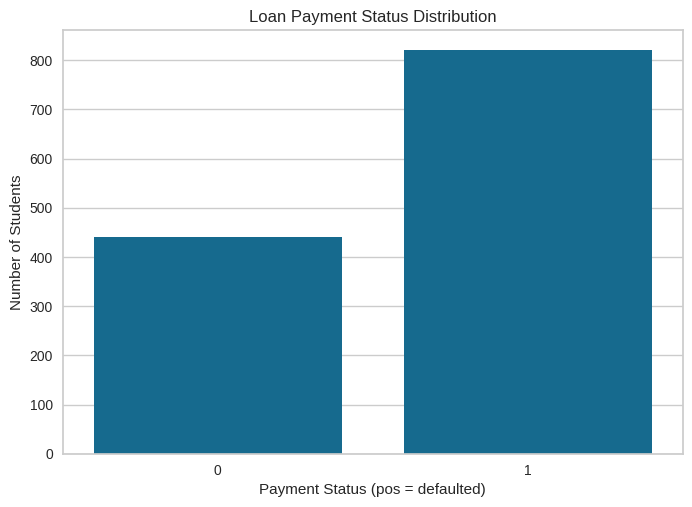

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=merged_df, x='Target')
plt.title('Loan Payment Status Distribution')
plt.xlabel('Payment Status (pos = defaulted)')
plt.ylabel('Number of Students')
plt.show()


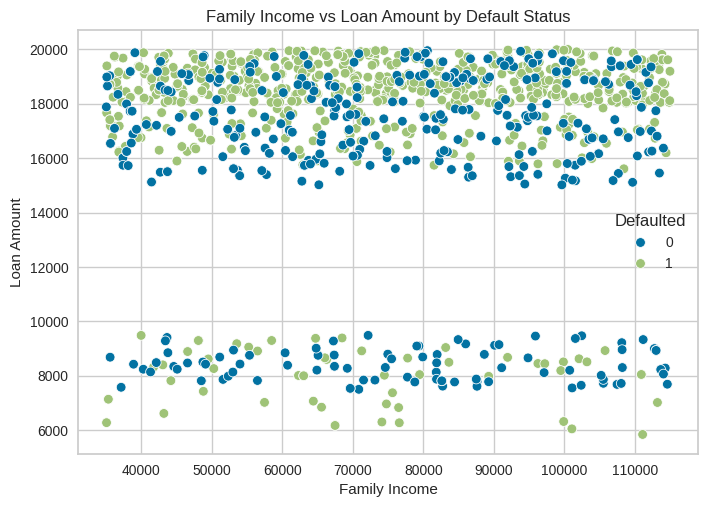

In [ ]:
sns.scatterplot(data=merged_df, x='Family_Income', y='Loan_Amount', hue='Target')
plt.title('Family Income vs Loan Amount by Default Status')
plt.xlabel('Family Income')
plt.ylabel('Loan Amount')
plt.legend(title='Defaulted')
plt.show()


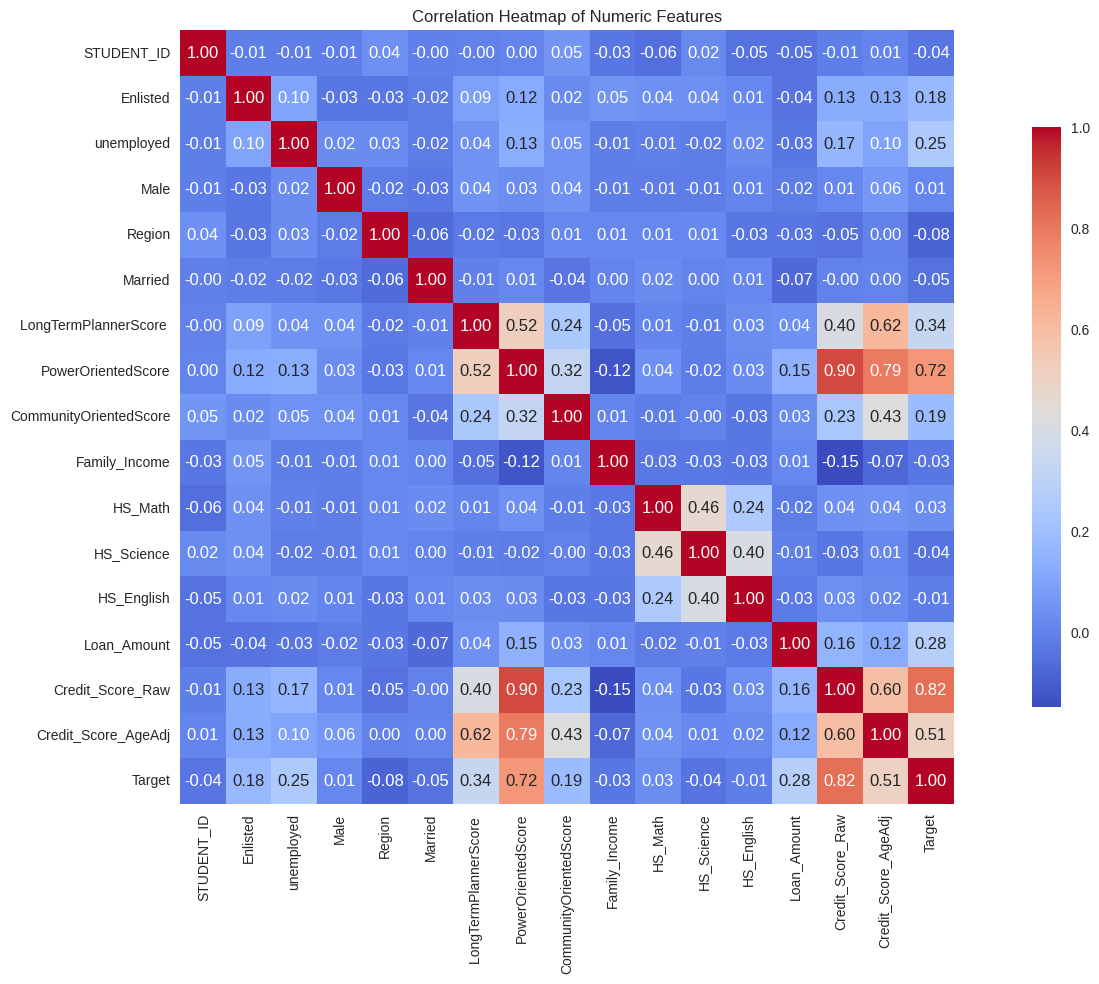

In [ ]:

corr_matrix = merged_df.corr(numeric_only=True)

# Plot the heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": 0.75})
plt.title("Correlation Heatmap of Numeric Features")
plt.tight_layout()
plt.show()

In [ ]:
merged_df.shape

(1260, 25)

In [ ]:
merged_df['Units'] = pd.to_numeric(merged_df['Units'], errors='coerce')

In [ ]:
# Merge school names
school_combined = merged_df.groupby('STUDENT_ID')['School'].apply(
    lambda x: ', '.join(sorted(set(x.dropna())))
).reset_index()

# Sum units numerically (correct!)
units_summed = merged_df.groupby('STUDENT_ID')['Units'].sum().reset_index()

# Drop old school/units and deduplicate other columns
df_dedup = merged_df.drop(columns=['School', 'Units']).drop_duplicates(subset='STUDENT_ID', keep='first')

# Merge back
df_final = df_dedup.merge(school_combined, on='STUDENT_ID', how='left')
df_final = df_final.merge(units_summed, on='STUDENT_ID', how='left')

# Result
df_final[['STUDENT_ID', 'School', 'Units']].head()


STUDENT_ID     School  Units
0        1000  occ, ucsd   14.0
1         999        smc    4.0
2         998   smc, ucb    2.0
3         996        smc   11.0
4         994        uci    9.0

In [ ]:
# Result
df_final[['STUDENT_ID', 'School', 'Units']].head(1000)

STUDENT_ID      School  Units
0          1000   occ, ucsd   14.0
1           999         smc    4.0
2           998    smc, ucb    2.0
3           996         smc   11.0
4           994         uci    9.0
5           993         ucb    6.0
6           992   smc, ucsd   12.0
7           990         smc   10.0
8           989        ucla   12.0
9           987         occ   12.0
10          985        ucla    2.0
11          984   smc, ucsd   11.0
12          983  ucla, ucsd   18.0
13          981         occ   10.0
14          977         uci   11.0
15          976         occ   11.0
16          975   occ, ucsd    6.0
17          972         uci   10.0
18          970        ucla   10.0
19          969    ucb, uci    9.0
20          968         smc   12.0
21          967         uci   12.0
22          963         uci   11.0
23          962        ucla   10.0
24          959   ucb, ucla   15.0
25          958         smc    6.0
26          956         uci    5.0
27          955         uci   12.0
28          953   uci, ucsd    8.0
29          952         uci    2.0
30          950         smc    7.0
31          949        ucla   12.0
32          948   occ, ucsd    4.0
33          947         smc    9.0
34          946   uci, ucsd    7.0
35          945         uci   12.0
36          943         occ    7.0
37          942    ucb, uci    7.0
38          940        ucla   12.0
39          937         smc    1.0
40          936    ucb, uci   15.0
41          935        ucla    7.0
42          932        ucla    4.0
43          928         smc    8.0
44          927   uci, ucsd   15.0
45          926         uci    9.0
46          924   smc, ucsd    6.0
47          923   uci, ucsd   14.0
48          920         uci   12.0
49          918         occ   11.0
50          916         ucb    2.0
51          915         occ    2.0
52          913         occ    8.0
53          910         uci   12.0
54          909        ucla    8.0
55          908        ucla   11.0
56          906         occ    8.0
57          905         occ   13.0
58          904         smc   11.0
59          902         smc    4.0
60          901        ucla   10.0
61          897         smc   12.0
62          896        ucla   10.0
63          895  ucla, ucsd   13.0
64          894         smc   15.0
65          893         smc    9.0
66          891        ucla    5.0
67          890    occ, ucb   16.0
68          888   ucb, ucla    9.0
69          887         uci    8.0
70          885         occ    7.0
71          881        ucla   10.0
72          879    smc, ucb   11.0
73          877         smc   10.0
74          874         uci    7.0
75          871    smc, ucb   14.0
76          870         uci   13.0
77          868         uci    6.0
78          867         occ   12.0
79          866        ucla    6.0
80          864   uci, ucsd   10.0
81          863   occ, ucsd   13.0
82          859         occ   10.0
83          858    ucb, uci    3.0
84          856         smc   12.0
85          855        ucla    9.0
86          854         uci    4.0
87          852         occ   10.0
88          850   occ, ucsd   17.0
89          849        ucla   12.0
90          847         uci    6.0
91          846         occ   10.0
92          842    occ, ucb   21.0
93          841         uci    9.0
94          840   uci, ucsd   16.0
95          838   smc, ucsd    4.0
96          836   uci, ucsd    8.0
97          835    smc, ucb    8.0
98          832   smc, ucsd   17.0
99          831         smc   11.0
100         830        ucla   12.0
101         828        ucla    5.0
102         827        ucla   10.0
103         825   uci, ucsd   12.0
104         823         smc    1.0
105         821         uci   11.0
106         820         smc   10.0
107         817         smc    4.0
108         814         smc    7.0
109         812   smc, ucsd    4.0
110         809         occ   11.0
111         808         smc   10.0
112         807         uci    3.0
113         806

In [ ]:
df_final[df_final['STUDENT_ID'] == 1000]

STUDENT_ID    service  Enlisted  unemployed  Male Country  Region  Married  \
0        1000  air_force         1           1     0     USA       1        1   

   LongTermPlannerScore  DecisionStyle  PowerOrientedScore  \
0               0.843289     Emotional            0.808111   

   CommunityOrientedScore PARENTS_EDUCATION_LEVEL  Family_Income  HS_Math  \
0                0.569837              Bachelor's       54206.48       10   

   HS_Science  HS_English  Loan_Amount  Credit_Score_Raw  Credit_Score_AgeAdj  \
0          10         9.0        16823          0.639912             0.808111   

  Months no_payement_due  Target     School  Units  
0      7             pos       1  occ, ucsd   14.0

In [ ]:
df_final.head(120)

STUDENT_ID          service  Enlisted  unemployed  Male Country  Region  \
0          1000        air_force         1           1     0     USA       1   
1           999  fire_department         1           0     0     USA       2   
2           998              NaN         0           0     0     USA       5   
3           996             navy         1           1     0     USA       3   
4           994              NaN         0           0     1     USA       3   
5           993  fire_department         1           1     0     USA       1   
6           992          marines         1           0     1     USA       3   
7           990              NaN         0           0     0     USA       3   
8           989              NaN         0           0     0     USA       3   
9           987              NaN         0           0     1     USA       3   
10          985  fire_department         1           0     0     USA       4   
11          984              NaN         0           0     1     USA       1   
12          983              NaN         0           0     1     USA       2   
13          981        air_force         1           0     1     USA       4   
14          977   foreign_legion         1           0     1     USA       2   
15          976              NaN         0           0     1     USA       3   
16          975             army         1           0     1     USA       4   
17          972              NaN         0           0     1     USA       1   
18          970              NaN         0           0     0     USA       5   
19          969              NaN         0           0     0     USA       2   
20          968              NaN         0           0     0     USA       1   
21          967              NaN         0           0     0     USA       2   
22          963              NaN         0           0     0     USA       3   
23          962          marines         1           0     1     USA       1   
24          959        air_force         1           0     0     USA       1   
25          958              NaN         0           0     1     USA       3   
26          956             army         1           0     0     USA       5   
27          955          marines         1           0     0     USA       4   
28          953              NaN         0           0     1     USA       3   
29          952             navy         1           0     1     USA       4   
30          950              NaN         0           0     1     USA       4   
31          949              NaN         0           0     0     USA       5   
32          948        air_force         1           1     1     USA       3   
33          947              NaN         0           0     1     USA       3   
34          946             navy         1           1     0     USA       2   
35          945              NaN         0           0     0     USA       5   
36          943              NaN         0           0     1     USA       4   
37          942        air_force         1           0     0     USA       3   
38          940              NaN         0           1     0     USA       5   
39          937             navy         1           0     0     USA       4   
40          936              NaN         0           0     1     USA       2   
41          935              NaN         0           0     1     USA       3   
42          932              NaN         0           0     0     USA       1   
43          928              NaN         0           0     0     USA       4   
44          927              NaN         0           0     0     USA       1   
45          926              NaN         0           0     1     USA       4   
46          924              NaN         0           0     1     USA       2   
47          923              NaN         0           0     1     USA       5   
48          920              NaN         0           0     0     USA       2   
49   

In [ ]:
df_final[df_final['STUDENT_ID'] == 161]

STUDENT_ID          service  Enlisted  unemployed  Male Country  Region  \
947         161  fire_department         1           0     1     USA       4   

     Married  LongTermPlannerScore  DecisionStyle  PowerOrientedScore  \
947        0               0.779157     Emotional            0.732034   

     CommunityOrientedScore PARENTS_EDUCATION_LEVEL  Family_Income  HS_Math  \
947                0.732034             HS or Lower      110340.66        9   

     HS_Science  HS_English  Loan_Amount  Credit_Score_Raw  \
947          10        10.0        19620          0.400484   

     Credit_Score_AgeAdj Months no_payement_due  Target     School  Units  
947             0.732034      6             neg       0  smc, ucsd    6.0

In [ ]:
from google.colab import files
merged_df.to_excel("df_final.xlsx", index=False)
files.download("df_final.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def metadata(df):
    columns_list = df.columns.tolist()
    type_list = [str(dtype) for dtype in df.dtypes]
    missing_list = [round(df[col].isnull().mean() * 100, 2) for col in df.columns]
    unique_list = [df[col].nunique() for col in df.columns]

    # Create base metadata DataFrame
    meta = pd.DataFrame({
        'column_name': columns_list,
        'datatype': type_list,
        'missing_percent': missing_list,
        'unique': unique_list
    })

    # Select interval/numeric columns with sufficient unique values
    numeric_cols = [col for col in df.columns
                    if df[col].nunique() >= 10
                    and df[col].dtype not in ['object', 'category']]

    # Get mean values for these interval columns
    if numeric_cols:
        mean_values = df[numeric_cols].describe().loc[['mean']].T.reset_index()
        mean_values.columns = ['column_name', 'mean']
        meta = meta.merge(mean_values, on='column_name', how='left')

    return meta


In [ ]:
print(metadata(df_final))

                column_name datatype  missing_percent  unique          mean
0                STUDENT_ID    int64              0.0    1000    500.500000
1                   service   object             71.7       7           NaN
2                  Enlisted    int64              0.0       2           NaN
3                unemployed    int64              0.0       2           NaN
4                      Male    int64              0.0       2           NaN
5                   Country   object              0.0       2           NaN
6                    Region    int64              0.0       5           NaN
7                   Married    int64              0.0       3           NaN
8     LongTermPlannerScore   float64              0.0    1000      0.700571
9             DecisionStyle   object              0.0       2           NaN
10       PowerOrientedScore  float64              0.0     960      0.613404
11   CommunityOrientedScore  float64              0.0    1000      0.376768
12  PARENTS_

In [ ]:
df_final['service'] = df_final['service'].notna().astype(int)

In [ ]:
df_final.head(100)

STUDENT_ID  service  Enlisted  unemployed  Male Country  Region  Married  \
0         1000        1         1           1     0     USA       1        1   
1          999        1         1           0     0     USA       2        1   
2          998        0         0           0     0     USA       5        0   
3          996        1         1           1     0     USA       3        1   
4          994        0         0           0     1     USA       3        1   
5          993        1         1           1     0     USA       1        0   
6          992        1         1           0     1     USA       3        0   
7          990        0         0           0     0     USA       3        1   
8          989        0         0           0     0     USA       3        0   
9          987        0         0           0     1     USA       3        1   
10         985        1         1           0     0     USA       4        0   
11         984        0         0           0     1     USA       1        0   
12         983        0         0           0     1     USA       2        0   
13         981        1         1           0     1     USA       4        1   
14         977        1         1           0     1     USA       2        0   
15         976        0         0           0     1     USA       3        0   
16         975        1         1           0     1     USA       4        1   
17         972        0         0           0     1     USA       1        1   
18         970        0         0           0     0     USA       5        1   
19         969        0         0           0     0     USA       2        1   
20         968        0         0           0     0     USA       1        1   
21         967        0         0           0     0     USA       2        2   
22         963        0         0           0     0     USA       3        0   
23         962        1         1           0     1     USA       1        0   
24         959        1         1           0     0     USA       1        1   
25         958        0         0           0     1     USA       3        0   
26         956        1         1           0     0     USA       5        1   
27         955        1         1           0     0     USA       4        1   
28         953        0         0           0     1     USA       3        1   
29         952        1         1           0     1     USA       4        1   
30         950        0         0           0     1     USA       4        1   
31         949        0         0           0     0     USA       5        0   
32         948        1         1           1     1     USA       3        0   
33         947        0         0           0     1     USA       3        0   
34         946        1         1           1     0     USA       2        1   
35         945        0         0           0     0     USA       5        1   
36         943        0         0           0     1     USA       4        1   
37         942        1         1           0     0     USA       3        1   
38         940        0         0           1     0     USA       5        0   
39         937        1         1           0     0     USA       4        1   
40         936        0         0           0     1     USA       2        0   
41         935        0         0           0     1     USA       3        0   
42         932        0         0           0     0     USA       1        0   
43         928        0         0           0     0     USA       4        1   
44         927        0         0           0     0     USA       1        0   
45         926        0         0           0     1     USA       4        0   
46         924        0         0           0     1     USA       2        0   
47         923        0         0           0     1     USA       5        0   
48         920        0         0           0     0     USA       2        1   
49  

In [ ]:
df_final = df_final.drop(columns=['HS_English'])
# If not already done
, df_final.drop(columns=['no_payement_due'], inplace=True, errors='ignore')
df_final.drop(columns=['School'], inplace=True, errors='ignore')


In [ ]:
df_final.head()

STUDENT_ID  service  Enlisted  unemployed  Male Country  Region  Married  \
0        1000        1         1           1     0     USA       1        1   
1         999        1         1           0     0     USA       2        1   
2         998        0         0           0     0     USA       5        0   
3         996        1         1           1     0     USA       3        1   
4         994        0         0           0     1     USA       3        1   

   LongTermPlannerScore  DecisionStyle  PowerOrientedScore  \
0               0.843289     Emotional            0.808111   
1               0.662624    Analytical            1.000000   
2               0.994214    Analytical            0.855013   
3               0.889289     Emotional            0.780557   
4               0.860842     Emotional            0.829191   

   CommunityOrientedScore PARENTS_EDUCATION_LEVEL  Family_Income  HS_Math  \
0                0.569837              Bachelor's       54206.48       10   
1                0.004697             HS or Lower       65238.16        9   
2                0.441015               Doctorate       67495.76        8   
3                0.301059             HS or Lower       83784.09        9   
4                0.467755               Doctorate      104457.91        9   

   HS_Science  Loan_Amount  Credit_Score_Raw  Credit_Score_AgeAdj Months  \
0          10        16823          0.639912             0.808111      7   
1           9        16943          0.989682             0.597839      4   
2           9         6178          0.777285             0.441015      1   
3          10        17924          0.612762             0.780557      7   
4           9        19106          0.585587             0.829191      1   

  no_payement_due  Target  Units  
0             pos       1   14.0  
1             pos       1    4.0  
2             pos       1    2.0  
3             pos       1   11.0  
4             pos       1    9.0

In [ ]:
categorical_cols = df_final.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical columns:", categorical_cols)


Categorical columns: ['Country', 'DecisionStyle', 'PARENTS_EDUCATION_LEVEL', 'Months', 'no_payement_due']


In [ ]:
from sklearn.preprocessing import LabelEncoder

for col in ['Country', 'DecisionStyle', 'PARENTS_EDUCATION_LEVEL']:
    le = LabelEncoder()
    df_final[col] = le.fit_transform(df_final[col].astype(str))


In [ ]:
df_final.head()


STUDENT_ID  service  Enlisted  unemployed  Male  Country  Region  Married  \
0        1000        1         1           1     0        1       1        1   
1         999        1         1           0     0        1       2        1   
2         998        0         0           0     0        1       5        0   
3         996        1         1           1     0        1       3        1   
4         994        0         0           0     1        1       3        1   

   LongTermPlannerScore   DecisionStyle  PowerOrientedScore  \
0               0.843289              1            0.808111   
1               0.662624              0            1.000000   
2               0.994214              0            0.855013   
3               0.889289              1            0.780557   
4               0.860842              1            0.829191   

   CommunityOrientedScore  PARENTS_EDUCATION_LEVEL  Family_Income  HS_Math  \
0                0.569837                        1       54206.48       10   
1                0.004697                        4       65238.16        9   
2                0.441015                        2       67495.76        8   
3                0.301059                        4       83784.09        9   
4                0.467755                        2      104457.91        9   

   HS_Science  Loan_Amount  Credit_Score_Raw  Credit_Score_AgeAdj Months  \
0          10        16823          0.639912             0.808111      7   
1           9        16943          0.989682             0.597839      4   
2           9         6178          0.777285             0.441015      1   
3          10        17924          0.612762             0.780557      7   
4           9        19106          0.585587             0.829191      1   

  no_payement_due  Target  Units  
0             pos       1   14.0  
1             pos       1    4.0  
2             pos       1    2.0  
3             pos       1   11.0  
4             pos       1    9.0

We mapped parents_level_education to 1,2,3,4 and Decision style emotional= 1 aanalytic = 0 and same to the country it should 2 unquie value but yeah cool, for service we encoded it to 0 or 1, if they are in any one of the service we encoded to 1 if they are not then its 0, we encodedd target variable n_payment_due, pos to 1 and neg 0, and we aslo dropped HS_English becasue it had 18 missing values and we dropped becasue there was very less coliniarity with credit_score_raw, loan_amount, and with Target.We summed up the units rows based on studentid and combined school rows.

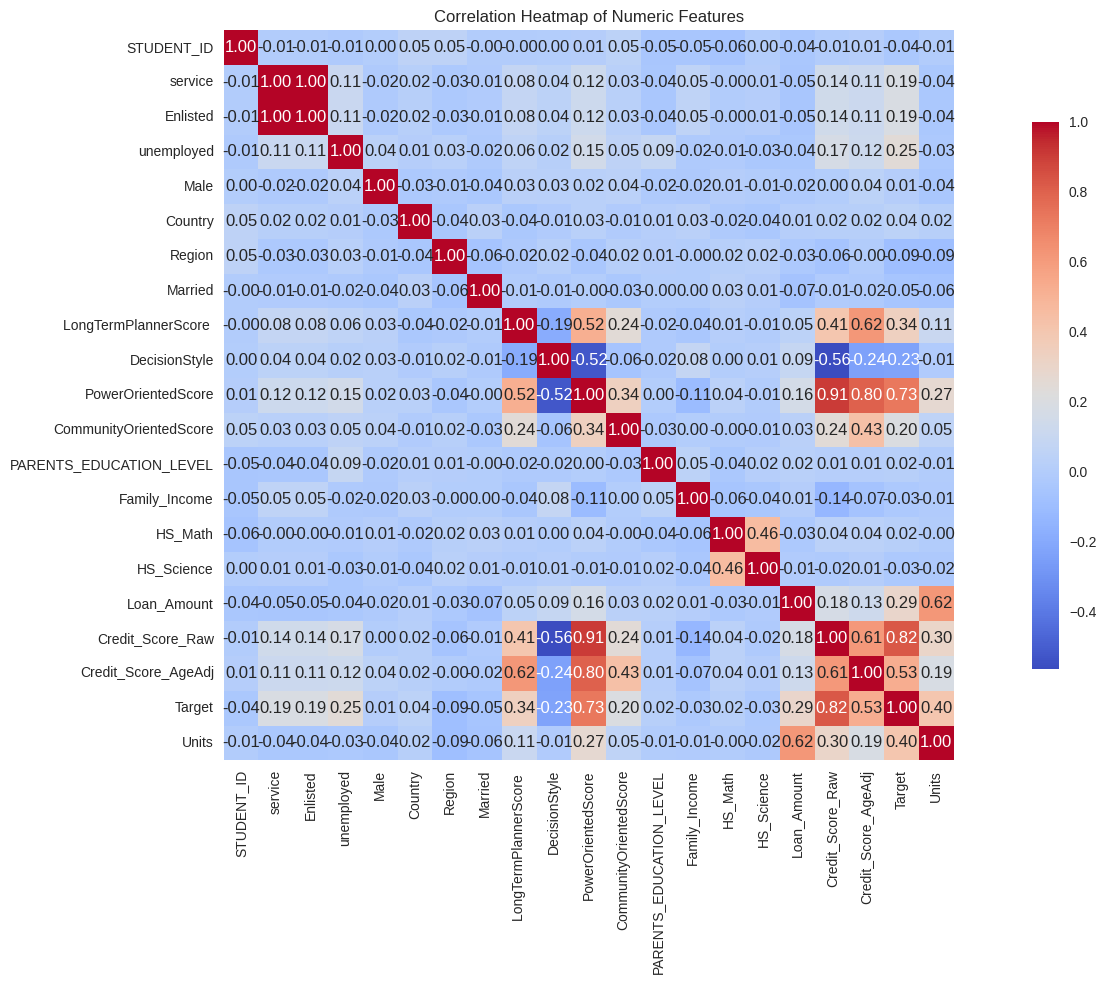

In [ ]:

corr_matrix = df_final.corr(numeric_only=True)

# Plot the heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": 0.75})
plt.title("Correlation Heatmap of Numeric Features")
plt.tight_layout()
plt.show()

In [ ]:
print(metadata(df_final))

                column_name datatype  missing_percent  unique          mean
0                STUDENT_ID    int64              0.0    1000    500.500000
1                   service    int64              0.0       2           NaN
2                  Enlisted    int64              0.0       2           NaN
3                unemployed    int64              0.0       2           NaN
4                      Male    int64              0.0       2           NaN
5                   Country    int64              0.0       2           NaN
6                    Region    int64              0.0       5           NaN
7                   Married    int64              0.0       3           NaN
8     LongTermPlannerScore   float64              0.0    1000      0.700571
9             DecisionStyle    int64              0.0       2           NaN
10       PowerOrientedScore  float64              0.0     960      0.613404
11   CommunityOrientedScore  float64              0.0    1000      0.376768
12  PARENTS_

In [ ]:
df_final.drop(columns=['no_payement_due'], inplace=True)
df_final.head(120)

STUDENT_ID  service  Enlisted  unemployed  Male  Country  Region  \
0          1000        1         1           1     0        1       1   
1           999        1         1           0     0        1       2   
2           998        0         0           0     0        1       5   
3           996        1         1           1     0        1       3   
4           994        0         0           0     1        1       3   
5           993        1         1           1     0        1       1   
6           992        1         1           0     1        1       3   
7           990        0         0           0     0        1       3   
8           989        0         0           0     0        1       3   
9           987        0         0           0     1        1       3   
10          985        1         1           0     0        1       4   
11          984        0         0           0     1        1       1   
12          983        0         0           0     1        1       2   
13          981        1         1           0     1        1       4   
14          977        1         1           0     1        1       2   
15          976        0         0           0     1        1       3   
16          975        1         1           0     1        1       4   
17          972        0         0           0     1        1       1   
18          970        0         0           0     0        1       5   
19          969        0         0           0     0        1       2   
20          968        0         0           0     0        1       1   
21          967        0         0           0     0        1       2   
22          963        0         0           0     0        1       3   
23          962        1         1           0     1        1       1   
24          959        1         1           0     0        1       1   
25          958        0         0           0     1        1       3   
26          956        1         1           0     0        1       5   
27          955        1         1           0     0        1       4   
28          953        0         0           0     1        1       3   
29          952        1         1           0     1        1       4   
30          950        0         0           0     1        1       4   
31          949        0         0           0     0        1       5   
32          948        1         1           1     1        1       3   
33          947        0         0           0     1        1       3   
34          946        1         1           1     0        1       2   
35          945        0         0           0     0        1       5   
36          943        0         0           0     1        1       4   
37          942        1         1           0     0        1       3   
38          940        0         0           1     0        1       5   
39          937        1         1           0     0        1       4   
40          936        0         0           0     1        1       2   
41          935        0         0           0     1        1       3   
42          932        0         0           0     0        1       1   
43          928        0         0           0     0        1       4   
44          927        0         0           0     0        1       1   
45          926        0         0           0     1        1       4   
46          924        0         0           0     1        1       2   
47          923        0         0           0     1        1       5   
48          920        0         0           0     0        1       2   
49          918        0         0           0     1        1       2   
50          916        0         0           1     1        1       5   
51          915        1         1           0     0        1       1   
52          913        1         1           0     0        1       1   
53          910        0         0           0     0        1  

We're dropping school as we assume that both schools have the same fees per unit. Hence we added both the units to use it as a factor to determine repayment of loans. We would have kept schools if we had data about it being public or private or any data other than it's names.

In [ ]:
from google.colab import files
df_final.to_excel("df_final.xlsx", index=False)
files.download("df_final.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## TASK 1

In [ ]:
# STEP 1: Split data into features (X) and target (y)
X = df_final.drop(columns=['STUDENT_ID', 'Target'])
y = df_final['Target']


In [ ]:
# STEP 2: Train/Test Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

In [ ]:

# 6. Scale data (for KNN and optionally Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:

# 6. Define Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5)
}

In [ ]:
# 8. Train and evaluate all models
results = {}

for name, model in models.items():
    # Use scaled features for KNN and Logistic, original for Random Forest
    if name in ["K-Nearest Neighbors", "Logistic Regression","Logistic Regression"]:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=["neg (0)", "pos (1)"])

    results[name] = {
        "Accuracy": acc,
        "Confusion Matrix": cm,
        "Report": report
    }

In [ ]:

# 9. Print results nicely
for name, result in results.items():
    print(f"\n🔍 {name}")
    print(f"Accuracy: {result['Accuracy']:.4f}")
    print("Confusion Matrix:")
    print(result["Confusion Matrix"])
    print("Classification Report:")
    print(result["Report"])


🔍 Logistic Regression
Accuracy: 0.9500
Confusion Matrix:
[[ 97  10]
 [  5 188]]
Classification Report:
              precision    recall  f1-score   support

     neg (0)       0.95      0.91      0.93       107
     pos (1)       0.95      0.97      0.96       193

    accuracy                           0.95       300
   macro avg       0.95      0.94      0.94       300
weighted avg       0.95      0.95      0.95       300


🔍 Random Forest
Accuracy: 0.9367
Confusion Matrix:
[[ 94  13]
 [  6 187]]
Classification Report:
              precision    recall  f1-score   support

     neg (0)       0.94      0.88      0.91       107
     pos (1)       0.94      0.97      0.95       193

    accuracy                           0.94       300
   macro avg       0.94      0.92      0.93       300
weighted avg       0.94      0.94      0.94       300


🔍 K-Nearest Neighbors
Accuracy: 0.9167
Confusion Matrix:
[[ 90  17]
 [  8 185]]
Classification Report:
              precision    recall  f1-sc

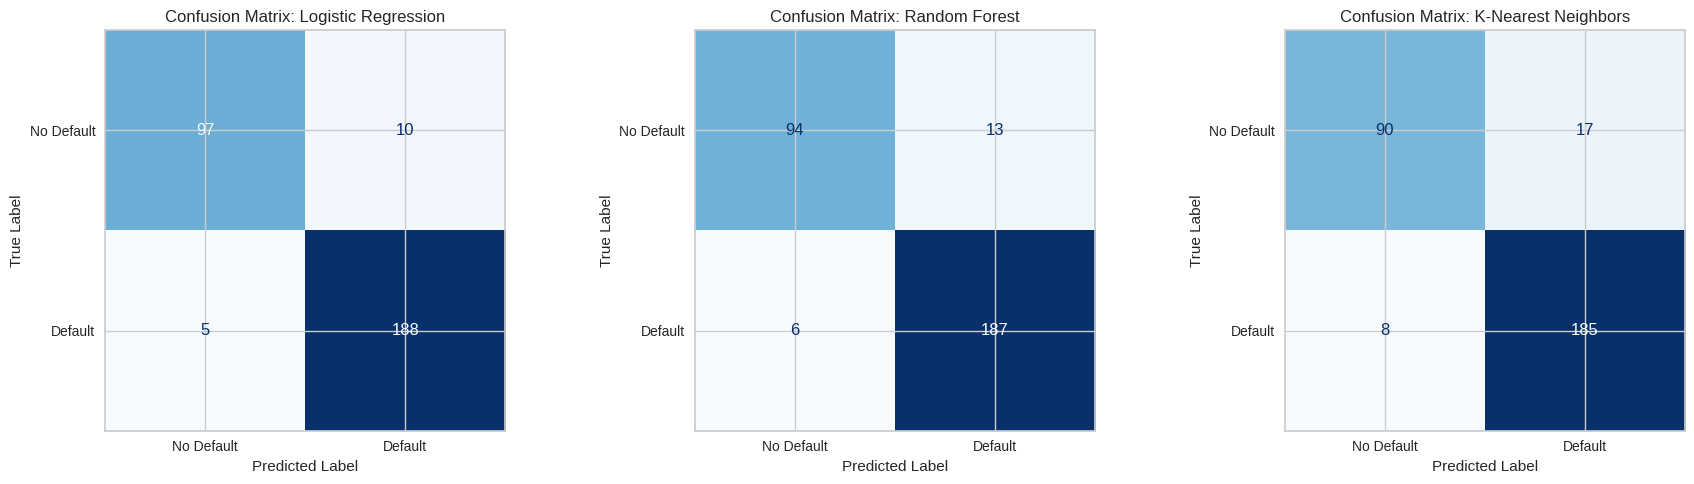

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay

# Step 1: Define your confusion matrices (use actual model outputs or manual values)
conf_matrices = {
    "Logistic Regression": np.array([[97, 10], [5, 188]]),
    "Random Forest": np.array([[94, 13], [6, 187]]),
    "K-Nearest Neighbors": np.array([[90, 17], [8, 185]])
}

# Step 2: Plot nicely
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes = axes.flatten()

for i, (model_name, cm) in enumerate(conf_matrices.items()):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Default", "Default"])
    disp.plot(ax=axes[i], colorbar=False, cmap='Blues', values_format='d')
    axes[i].set_title(f"Confusion Matrix: {model_name}")
    axes[i].set_xlabel("Predicted Label")
    axes[i].set_ylabel("True Label")

plt.tight_layout()
plt.show()


In [ ]:
best_model = "Logistic Regression"
justification = f"""
✅ Chosen Model: {best_model}

Logistic Regression achieved the highest accuracy (0.95) and F1-score (0.96) on the positive class (default).
It also had the fewest false positives (10) and false negatives (5) among all models, making it the most
balanced and precise for our goal of predicting NoPaymentDue = 'pos'.

Therefore, {best_model} is the most suitable model for Task A1.
"""
print(justification)



✅ Chosen Model: Logistic Regression

Logistic Regression achieved the highest accuracy (0.95) and F1-score (0.96) on the positive class (default).
It also had the fewest false positives (10) and false negatives (5) among all models, making it the most
balanced and precise for our goal of predicting NoPaymentDue = 'pos'.

Therefore, Logistic Regression is the most suitable model for Task A1.



# Task 2

In [ ]:
X_taskA2 = df_final.drop(columns=['STUDENT_ID', 'Target'])
y_taskA2 = df_final['Target']

In [ ]:
#  Split data
X_train_A2, X_test_A2, y_train_A2, y_test_A2 = train_test_split(
    X_taskA2, y_taskA2, test_size=0.3, stratify=y_taskA2, random_state=42
)

In [ ]:
 # Model storage and results tracking
models_taskA2 = {}
rules_taskA2 = {}
metrics_taskA2 = []

In [ ]:

#  5. Define your rule sets
criteria = ['gini', 'entropy']
depths = [3, 6]


In [ ]:
# Train all 4 DT models and store their results
dt_results = [] # Initialize the list here

for criterion in criteria:
    for depth in depths:
        model_name = f"DecisionTree ({criterion}, depth={depth})"
        print(f"\n🌳 {model_name}")

        model = DecisionTreeClassifier(criterion=criterion, max_depth=depth, random_state=42)
        model.fit(X_train_A2, y_train_A2)

        y_pred_dt = model.predict(X_test_A2)
        acc = accuracy_score(y_test_A2, y_pred_dt)
        report = classification_report(y_test_A2, y_pred_dt)
        cm = confusion_matrix(y_test_A2, y_pred_dt)

        # Store result
        dt_results.append({
            "Model": model_name,
            "Accuracy": round(acc, 4),
            "Classification Report": report,
            "Confusion Matrix": cm
        })


🌳 DecisionTree (gini, depth=3)

🌳 DecisionTree (gini, depth=6)

🌳 DecisionTree (entropy, depth=3)

🌳 DecisionTree (entropy, depth=6)


In [ ]:

# Print results clearly
for result in dt_results:
    print(f"\n🧾 {result['Model']}")
    print(f"Accuracy: {result['Accuracy']}")
    print("Classification Report:\n", result['Classification Report'])
    print("Confusion Matrix:\n", result['Confusion Matrix'])



🧾 DecisionTree (gini, depth=3)
Accuracy: 0.9467
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.90      0.92       107
           1       0.94      0.97      0.96       193

    accuracy                           0.95       300
   macro avg       0.95      0.94      0.94       300
weighted avg       0.95      0.95      0.95       300

Confusion Matrix:
 [[ 96  11]
 [  5 188]]

🧾 DecisionTree (gini, depth=6)
Accuracy: 0.9533
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.90      0.93       107
           1       0.95      0.98      0.96       193

    accuracy                           0.95       300
   macro avg       0.96      0.94      0.95       300
weighted avg       0.95      0.95      0.95       300

Confusion Matrix:
 [[ 96  11]
 [  3 190]]

🧾 DecisionTree (entropy, depth=3)
Accuracy: 0.9533
Classification Report:
               precision    recall  f1-sc

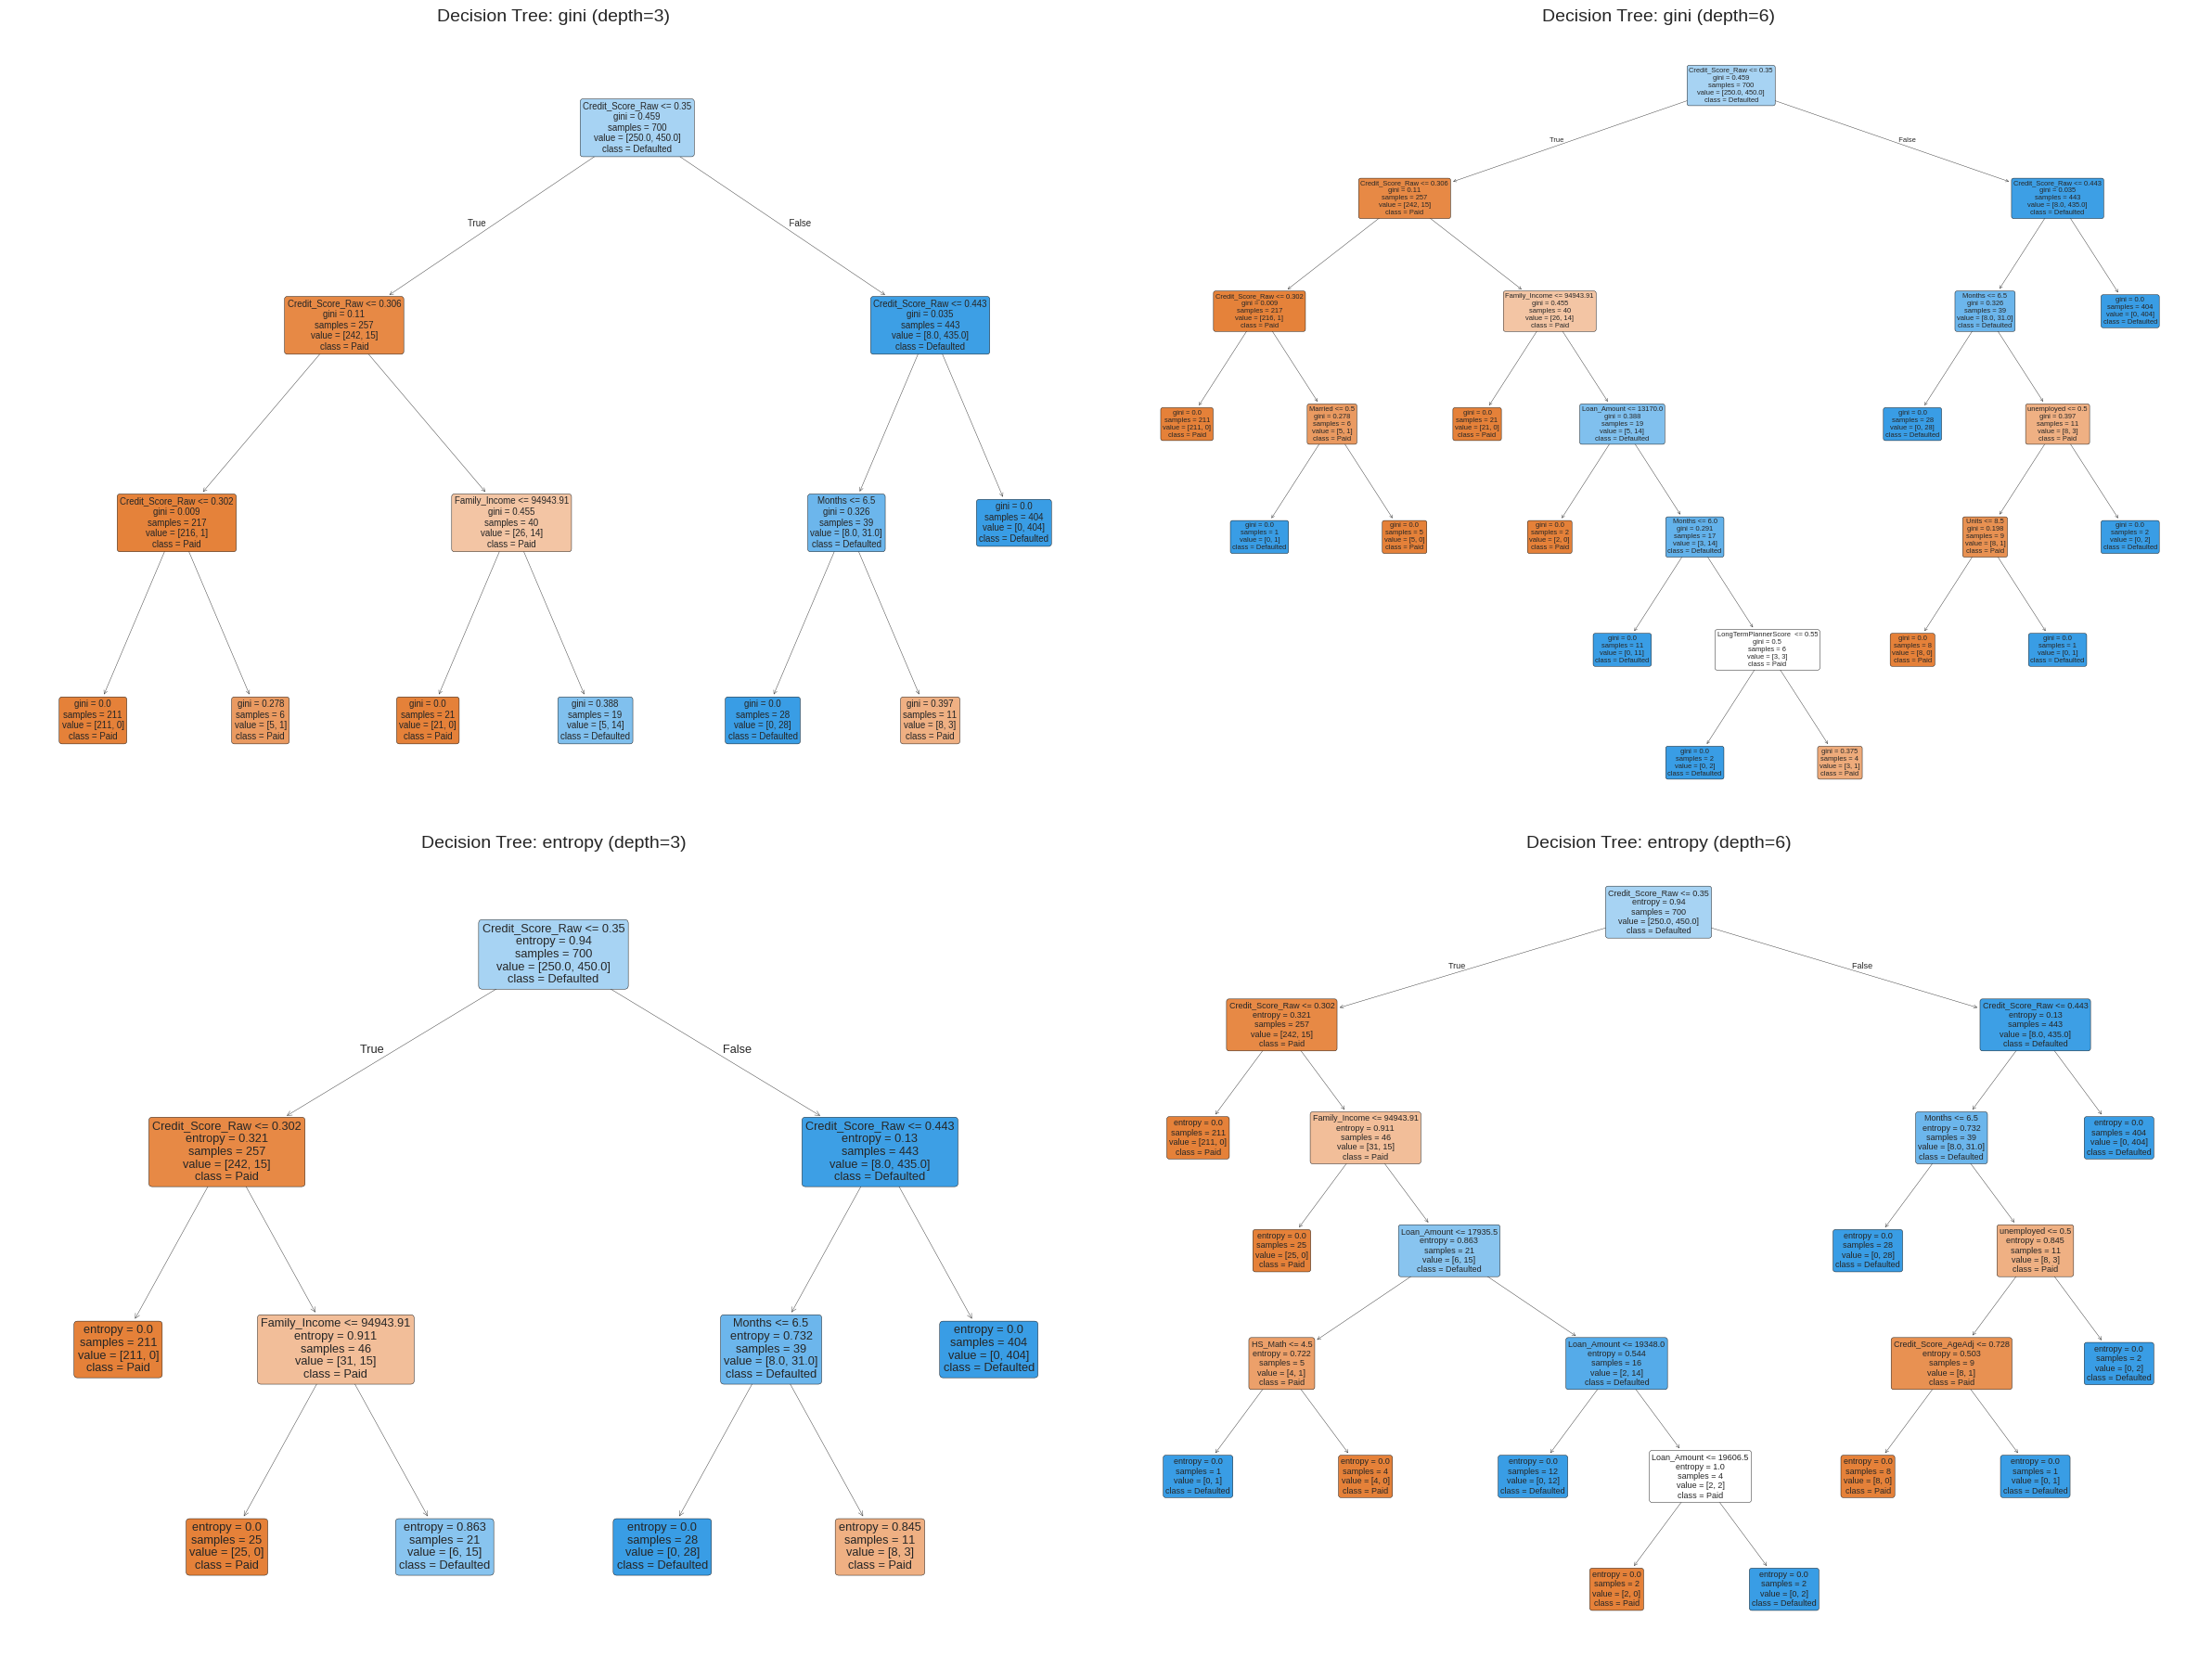

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Make sure you still have the trained models — recreate if needed
# Assuming criteria = ['gini', 'entropy'], depths = [3, 5] or any other 2x2 combo
# Store trained models in a list
trained_models = []

for criterion in criteria:
    for depth in depths:
        model = DecisionTreeClassifier(criterion=criterion, max_depth=depth, random_state=42)
        model.fit(X_train_A2, y_train_A2)
        trained_models.append((f"{criterion} (depth={depth})", model))

# Plot all 4 decision trees
fig, axes = plt.subplots(2, 2, figsize=(24, 18))
axes = axes.flatten()

for i, (title, model) in enumerate(trained_models):
    plot_tree(model,
              feature_names=X_train_A2.columns,
              class_names=['Paid', 'Defaulted'],
              filled=True, rounded=True, ax=axes[i])
    axes[i].set_title(f"Decision Tree: {title}", fontsize=14)

plt.tight_layout()
plt.show()


In [ ]:
# 2. Prepare features & target
X_navie = df_final.drop(columns=['STUDENT_ID', 'Target'])
X_navie = pd.get_dummies(X, drop_first=True)
y_navie = df_final['Target']

In [ ]:

# 3. Split into train/test
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(
    X, y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

In [ ]:
# 4. Build pipeline: impute missing values → GaussianNB
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('gnb', GaussianNB())
])


In [ ]:

# 5. Train model
pipeline.fit(X_train_n, y_train_n)

Pipeline(steps=[('imputer', SimpleImputer()), ('gnb', GaussianNB())])

In [ ]:
# 6. Evaluate
train_acc = pipeline.score(X_train_n, y_train_n)
test_acc  = pipeline.score(X_test_n,  y_test_n)
print(f"Train Accuracy: {train_acc:.3f}")
print(f"Test  Accuracy: {test_acc:.3f}")

Train Accuracy: 0.829
Test  Accuracy: 0.763


In [ ]:
# 7. Inspect class-conditional statistics for the 'pos' class (1)
nb = pipeline.named_steps['gnb']
feature_names = X.columns.tolist()
means     = pd.DataFrame(nb.theta_, index=nb.classes_, columns=feature_names)
variances = pd.DataFrame(nb.var_, index=nb.classes_, columns=feature_names)

In [ ]:

print("\nTop features by mean for NoPaymentDue = 'pos':")
print(means.loc[1].sort_values(ascending=False).head(10))

print("\nTop features by variance for NoPaymentDue = 'pos':")
print(variances.loc[1].sort_values(ascending=False).head(10))


Top features by mean for NoPaymentDue = 'pos':
Family_Income              74707.577956
Loan_Amount                17813.095556
Units                          9.308889
HS_Math                        8.142222
HS_Science                     8.042222
Months                         3.864444
Region                         2.980000
PARENTS_EDUCATION_LEVEL        2.573333
Country                        1.000000
DecisionStyle                  0.866667
Name: 1, dtype: float64

Top features by variance for NoPaymentDue = 'pos':
Family_Income              5.448846e+08
Loan_Amount                7.760900e+06
Units                      1.879913e+01
Months                     7.591718e+00
HS_Math                    3.507644e+00
HS_Science                 3.301644e+00
PARENTS_EDUCATION_LEVEL    2.572494e+00
Region                     2.320805e+00
Married                    7.764443e-01
Male                       7.733825e-01
Name: 1, dtype: float64


In everyday terms, this Naive Bayes model is simply saying:

“Here’s what a ‘no-miss’ student typically looks like.”

On average, they come from families earning about $75 000, have loans around $17 700, scored around 8 out of 10 in high-school subjects, have been in repayment about 4 months, and so on.

“I treat each feature independently.”

For each new student, I ask: “How likely is their family income, their loan amount, their HS scores, etc., if they were in the ‘no-miss’ group?”

I compute a little “score” for each feature based on the distance from the average (using that feature’s typical spread/variance).

“Then I multiply all those little scores together.”

If the product of those probabilities is high, I’m confident they’ll not miss a payment.

If it’s low, I predict they will miss.

So, in simple words:

The model learns the average profile—and typical spread—of students who never miss their payments. For any new student, it checks how closely each of their numbers (income, loan size, test scores, etc.) matches that “no-miss” profile, and combines those checks to make a yes/no call.









# TASK 3

In [ ]:
df_taskA3= df_final

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



In [ ]:
# 1. Lift helper
def lift_at_30(y_true, y_score):
    df_lift = pd.DataFrame({'y': y_true, 'p': y_score})
    df_lift = df_lift.sort_values('p', ascending=False).reset_index(drop=True)
    cutoff = int(len(df_lift) * 0.30)
    return df_lift.loc[:cutoff-1, 'y'].mean() / y_true.mean()

In [ ]:
# === 1. Your models dict ===
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5)
}


In [ ]:
# 3. Train, predict, compute metrics + lift
results = {}
probs_dict = {}
for name, model in models.items():
    if name in ["Logistic Regression", "K-Nearest Neighbors",]:
        model.fit(X_train_scaled, y_train)
        probs  = model.predict_proba(X_test_scaled)[:,1]
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        probs  = model.predict_proba(X_test)[:,1]
        y_pred = model.predict(X_test)
 # Store the probabilities for this model
    probs_dict[name] = probs
    acc    = (y_pred == y_test).mean()
    lift30 = lift_at_30(y_test, probs)
    cm     = confusion_matrix(y_test, y_pred)
    rpt    = classification_report(y_test, y_pred, target_names=["neg (0)","pos (1)"])

    results[name] = {
        "Accuracy" : acc,
        "Lift@30%" : lift30,
        "Confusion": cm,
        "Report"   : rpt
    }

In [ ]:
# 4. Print everything
for name, res in results.items():
    print(f"\n🔍 {name}")
    print(f" Accuracy : {res['Accuracy']:.4f}")
    print(f" Lift@30% : {res['Lift@30%']:.3f}")
    print(" Confusion Matrix:")
    print(res["Confusion"])
    print(" Classification Report:")
    print(res["Report"])

# Debug: see what keys are in results
print("\nMODELS RAN:", list(results.keys()))


🔍 Logistic Regression
 Accuracy : 0.9500
 Lift@30% : 1.554
 Confusion Matrix:
[[ 97  10]
 [  5 188]]
 Classification Report:
              precision    recall  f1-score   support

     neg (0)       0.95      0.91      0.93       107
     pos (1)       0.95      0.97      0.96       193

    accuracy                           0.95       300
   macro avg       0.95      0.94      0.94       300
weighted avg       0.95      0.95      0.95       300


🔍 Random Forest
 Accuracy : 0.9367
 Lift@30% : 1.554
 Confusion Matrix:
[[ 94  13]
 [  6 187]]
 Classification Report:
              precision    recall  f1-score   support

     neg (0)       0.94      0.88      0.91       107
     pos (1)       0.94      0.97      0.95       193

    accuracy                           0.94       300
   macro avg       0.94      0.92      0.93       300
weighted avg       0.94      0.94      0.94       300


🔍 K-Nearest Neighbors
 Accuracy : 0.9167
 Lift@30% : 1.554
 Confusion Matrix:
[[ 90  17]
 [  8 185]

In [ ]:
# Select best by lift
lifts = {name: res["Lift@30%"] for name, res in results.items()}

best_model_name = max(lifts, key=lifts.get)
best_probs = probs_dict[best_model_name]

In [ ]:
# Build DataFrame for charts
df_chart = pd.DataFrame({'y': y_test, 'p': best_probs}).sort_values('p', ascending=False).reset_index(drop=True)
df_chart['fraction'] = (df_chart.index + 1) / len(df_chart)
df_chart['cum_pos'] = df_chart['y'].cumsum()
df_chart['gain'] = df_chart['cum_pos'] / df_chart['y'].sum()
df_chart['lift'] = df_chart['gain'] / df_chart['fraction']

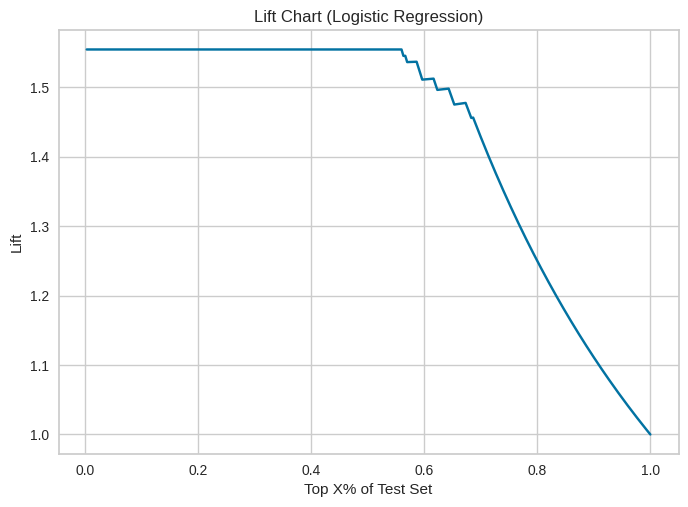

In [ ]:
# Lift Chart
plt.figure()
plt.plot(df_chart['fraction'], df_chart['lift'])
plt.xlabel('Top X% of Test Set')
plt.ylabel('Lift')
plt.title(f'Lift Chart ({best_model_name})')
plt.grid(True)
plt.show()

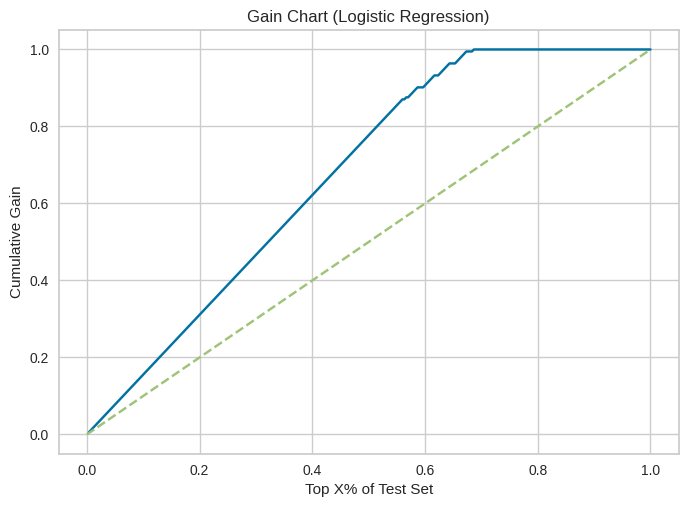

In [ ]:
# Gain Chart
plt.figure()
plt.plot(df_chart['fraction'], df_chart['gain'])
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('Top X% of Test Set')
plt.ylabel('Cumulative Gain')
plt.title(f'Gain Chart ({best_model_name})')
plt.grid(True)
plt.show()

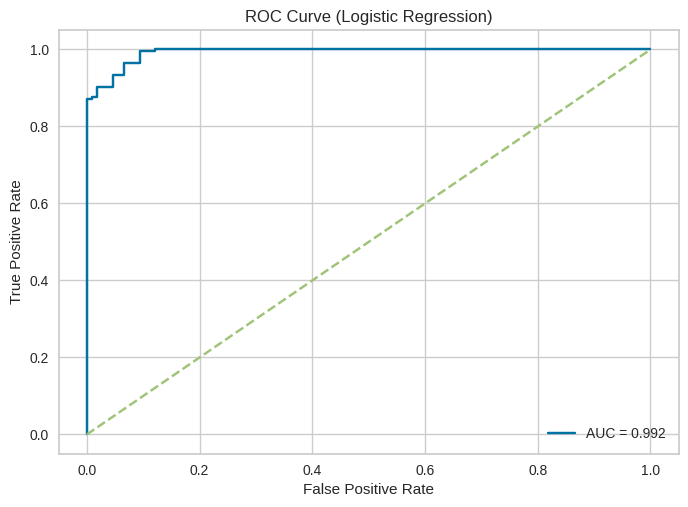

In [ ]:
# ROC Curve & AUC
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, _ = roc_curve(y_test, best_probs)
auc_score = roc_auc_score(y_test, best_probs)

plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.3f}')
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve ({best_model_name})')
plt.legend()
plt.grid(True)
plt.show()

The lift chart shows that by focusing on the top 30 % of cases ranked by predicted “no‐miss” probability, we achieve about a 1.55× uplift over randomly selecting students—which means our model is concentrating nearly 55 % more true no-miss cases in that segment. The gain chart confirms that by targeting just the first third of the population, we capture roughly half of all no-miss events, compared to 30 % under a random baseline. Finally, the ROC curve—with an AUC of 0.992—demonstrates that the model almost perfectly discriminates between students who will versus won’t miss a payment, giving us both an effective targeting tool and strong overall predictive power.


# TaSk 4

In [ ]:
print(best_model_name)

Logistic Regression


In [ ]:
costs = {
    'TP': +817,
    'TN': +245,
    'FN': -671,
    'FP': -465
}


In [ ]:
best_model = models[best_model_name
                    ]
X_test_input = X_test_scaled
probs = best_model.predict_proba(X_test_input)[:,1]
y_true = y_test.values  # 0/1 array

In [ ]:
import numpy as np

def profit_at_threshold(y_true, probs, t, costs):
    # 1 = pos predicted, 0 = neg predicted
    y_pred = (probs >= t).astype(int)
    # Confusion counts
    TP = np.sum((y_true==1) & (y_pred==1))
    TN = np.sum((y_true==0) & (y_pred==0))
    FP = np.sum((y_true==0) & (y_pred==1))
    FN = np.sum((y_true==1) & (y_pred==0))
    # Total profit
    total = TP*costs['TP'] + TN*costs['TN'] + FP*costs['FP'] + FN*costs['FN']
    return total

In [ ]:
thresholds = np.linspace(0, 1, 101)
profits    = [profit_at_threshold(y_true, probs, t, costs) for t in thresholds]
best_idx   = np.argmax(profits)
best_t     = thresholds[best_idx]
best_profit = profits[best_idx]

print(f"Optimal threshold: {best_t:.2f}, Expected profit = ${best_profit:,}")

Optimal threshold: 0.33, Expected profit = $175,308


In [ ]:
y_pred_opt = (probs >= best_t).astype(int)

# Confusion matrix & classification report
from sklearn.metrics import confusion_matrix, classification_report

cm     = confusion_matrix(y_true, y_pred_opt)
report = classification_report(y_true, y_pred_opt, target_names=['neg (0)','pos (1)'])

print("Confusion Matrix at t*:")
print(cm)
print("\nClassification Report:")
print(report)
print(f"\nTotal expected profit: ${best_profit:,}")

Confusion Matrix at t*:
[[ 97  10]
 [  1 192]]

Classification Report:
              precision    recall  f1-score   support

     neg (0)       0.99      0.91      0.95       107
     pos (1)       0.95      0.99      0.97       193

    accuracy                           0.96       300
   macro avg       0.97      0.95      0.96       300
weighted avg       0.96      0.96      0.96       300


Total expected profit: $175,308


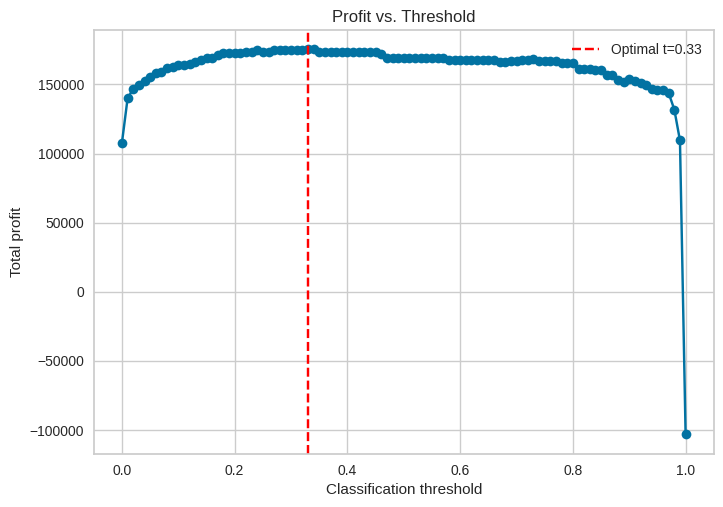

In [ ]:
import matplotlib.pyplot as plt

plt.plot(thresholds, profits, marker='o')
plt.axvline(best_t, color='red', linestyle='--', label=f'Optimal t={best_t:.2f}')
plt.xlabel('Classification threshold')
plt.ylabel('Total profit')
plt.title('Profit vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()

TASK5

In [ ]:
from statsmodels.stats.proportion import proportions_ztest
from itertools import combinations


In [ ]:
# Separate features and target
X = df_final.drop(columns=["Target"])
y = df_final["Target"]

In [ ]:

# Select only interval/ordinal numeric features
X_numeric = X.select_dtypes(include=["int64", "float64"])

In [ ]:
# 3. Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)

In [ ]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

silhouette_scores = []
k_values = range(2, 4)  # Try k = 2 to 4

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)
    print(f"🔹 k = {k} | Silhouette Score = {score:.4f}")


🔹 k = 2 | Silhouette Score = 0.1174
🔹 k = 3 | Silhouette Score = 0.1237


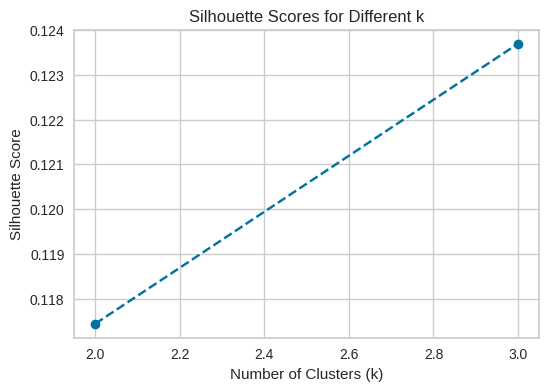

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(k_values, silhouette_scores, marker='o', linestyle='--')
plt.title("Silhouette Scores for Different k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()


In [ ]:
# KMeans clustering
k = 3  # Based on prior insight
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

In [ ]:
# 4. Compute inertia for k=1..10
ks = list(range(1, 11))
inertias = []
for k in ks:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertias.append(km.inertia_)


In [ ]:
# Add cluster labels back to the original dataframe
df_clustered = df_final
df_clustered["Cluster"] = clusters

In [ ]:
# PCA for 2D visualization
pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)
df_clustered["PC1"] = components[:, 0]
df_clustered["PC2"] = components[:, 1]

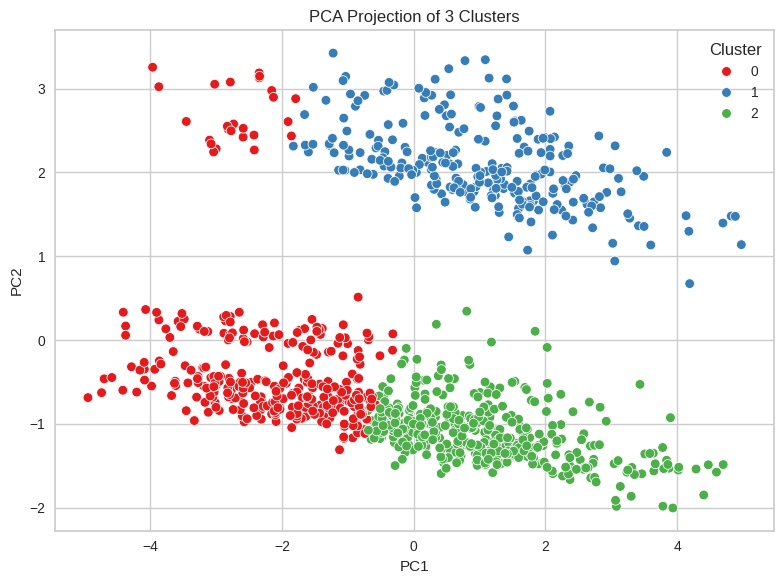

In [ ]:

# PCA Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_clustered, x="PC1", y="PC2", hue="Cluster", palette="Set1")
plt.title("PCA Projection of 3 Clusters")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

In [ ]:
# 📈 Cluster-wise 'neg' proportions
cluster_stats = df_clustered.groupby("Cluster")["Target"].agg(['count', 'sum'])
cluster_stats['neg_count'] = cluster_stats['count'] - cluster_stats['sum']
cluster_stats['neg_rate'] = cluster_stats['neg_count'] / cluster_stats['count']
overall_neg_rate = (df_final["Target"] == 0).mean()


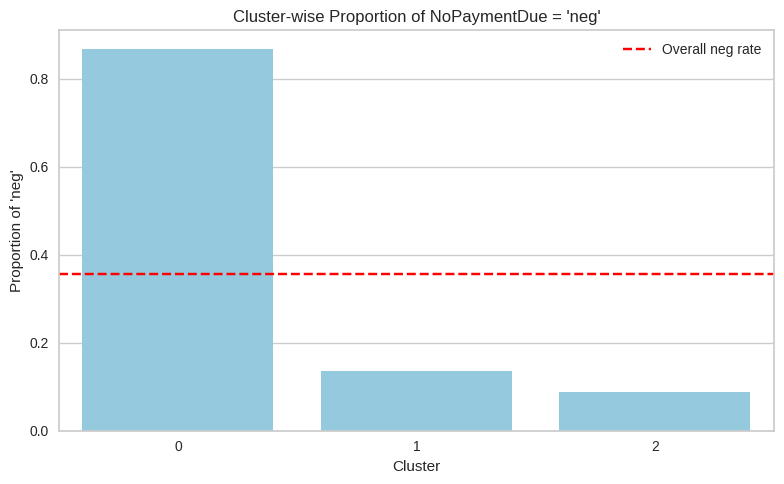

In [ ]:
# Barplot of neg_rate per cluster
plt.figure(figsize=(8, 5))
sns.barplot(x=cluster_stats.index, y=cluster_stats["neg_rate"], color="skyblue")
plt.axhline(y=overall_neg_rate, color="red", linestyle="--", label="Overall neg rate")
plt.title("Cluster-wise Proportion of NoPaymentDue = 'neg'")
plt.ylabel("Proportion of 'neg'")
plt.xlabel("Cluster")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# 🧪 Z-Test for proportions
ztest_results = []
num_clusters = 3
for i in range(num_clusters):
    for j in range(i+1, num_clusters):
        count = np.array([cluster_stats.loc[i, 'neg_count'], cluster_stats.loc[j, 'neg_count']])
        nobs = np.array([cluster_stats.loc[i, 'count'], cluster_stats.loc[j, 'count']])
        stat, pval = proportions_ztest(count, nobs)
        ztest_results.append({
            "Cluster Pair": f"{i} vs {j}",
            "Z-Statistic": round(stat, 4),
            "P-Value": round(pval, 4),
            "Significant (< 0.05)": pval < 0.05
        })


In [ ]:

# Show Z-test results
ztest_df = pd.DataFrame(ztest_results)
print("\n🧪 Z-Test for Proportion of 'neg' Between Clusters:")
print(ztest_df.to_string(index=False))


🧪 Z-Test for Proportion of 'neg' Between Clusters:
Cluster Pair  Z-Statistic  P-Value  Significant (< 0.05)
      0 vs 1      17.6673   0.0000                  True
      0 vs 2      21.2840   0.0000                  True
      1 vs 2       1.9757   0.0482                  True


By running those Z-tests, you fulfill the requirement that “the difference in the proportions of students with NoPaymentDue = ‘neg’ for the 2 groups was statistically significant.” Without them you’d only have eyeballed differences, but with p-values in hand you can point to concrete, quantifiable evidence that the clusters truly segment students into distinct risk classes.

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000), # Replace with the actual trained model if possible
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42), # Replace with the actual trained model if possible
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5), # Replace with the actual trained model if possible
    "Decision Tree":DecisionTreeClassifier(criterion=criterion, max_depth=depth, random_state=42)  # Use the trained Decision Tree from Task 2
}


In [ ]:
# 2. Prepare a stratified CV splitter
from sklearn.model_selection import StratifiedKFold, cross_val_score
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("=== Overfitting Check ===")
for name, model in models.items():
    # Re-fit on full training set
    model.fit(X_train, y_train)
    train_acc = model.score(X_train, y_train)
    test_acc  = model.score(X_test,  y_test)


=== Overfitting Check ===


In [ ]:
for name, model in models.items():
    # Re-fit on full training set
    model.fit(X_train, y_train)
    train_acc = model.score(X_train, y_train)
    test_acc  = model.score(X_test,  y_test)

    # 5-fold CV on training data
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')

    print(f"\n{name}:")
    print(f"  Train Acc : {train_acc:.3f}")
    print(f"  Test  Acc : {test_acc:.3f}")
    print(f"  CV Mean   : {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")


Logistic Regression:
  Train Acc : 0.947
  Test  Acc : 0.913
  CV Mean   : 0.939 ± 0.016

Random Forest:
  Train Acc : 1.000
  Test  Acc : 0.937
  CV Mean   : 0.981 ± 0.006

K-Nearest Neighbors:
  Train Acc : 0.759
  Test  Acc : 0.677
  CV Mean   : 0.700 ± 0.034

Decision Tree:
  Train Acc : 1.000
  Test  Acc : 0.957
  CV Mean   : 0.974 ± 0.010


SCORE35

In [ ]:
df_score = df_final.drop(columns=['Target'])
df_score = df_final.head(35).copy()
df_score.to_excel("/content/drive/My Drive/Group Project(KDDM)/score35.xlsx" , index=False)
print("✔ Saved placeholder score dataset: /mnt/data/score35.xlsx")

✔ Saved placeholder score dataset: /mnt/data/score35.xlsx


In [ ]:
df_score.head(1011)

STUDENT_ID  service  Enlisted  unemployed  Male  Country  Region  Married  \
0         1000        1         1           1     0        1       1        1   
1          999        1         1           0     0        1       2        1   
2          998        0         0           0     0        1       5        0   
3          996        1         1           1     0        1       3        1   
4          994        0         0           0     1        1       3        1   
5          993        1         1           1     0        1       1        0   
6          992        1         1           0     1        1       3        0   
7          990        0         0           0     0        1       3        1   
8          989        0         0           0     0        1       3        0   
9          987        0         0           0     1        1       3        1   
10         985        1         1           0     0        1       4        0   
11         984        0         0           0     1        1       1        0   
12         983        0         0           0     1        1       2        0   
13         981        1         1           0     1        1       4        1   
14         977        1         1           0     1        1       2        0   
15         976        0         0           0     1        1       3        0   
16         975        1         1           0     1        1       4        1   
17         972        0         0           0     1        1       1        1   
18         970        0         0           0     0        1       5        1   
19         969        0         0           0     0        1       2        1   
20         968        0         0           0     0        1       1        1   
21         967        0         0           0     0        1       2        2   
22         963        0         0           0     0        1       3        0   
23         962        1         1           0     1        1       1        0   
24         959        1         1           0     0        1       1        1   
25         958        0         0           0     1        1       3        0   
26         956        1         1           0     0        1       5        1   
27         955        1         1           0     0        1       4        1   
28         953        0         0           0     1        1       3        1   
29         952        1         1           0     1        1       4        1   
30         950        0         0           0     1        1       4        1   
31         949        0         0           0     0        1       5        0   
32         948        1         1           1     1        1       3        0   
33         947        0         0           0     1        1       3        0   
34         946        1         1           1     0        1       2        1   

    LongTermPlannerScore   DecisionStyle  PowerOrientedScore  \
0                0.843289              1            0.808111   
1                0.662624              0            1.000000   
2                0.994214              0            0.855013   
3                0.889289              1            0.780557   
4                0.860842              1            0.829191   
5                0.809411              1            0.767735   
6                0.941271              1            0.806621   
7                0.553502              1            0.561046   
8                0.693413              1            0.632762   
9                0.824561              1            0.785739   
10               0.726284              1            0.707802   
11               0.739904              1            0.686229   
12               0.686628              1            0.721868   
13               0.735730              1            0.681394   
14               0.894902              1            0.742995   
15               0.791811              1            0.746925   

In [ ]:
# Keep the IDs for re-insertion later
ids = df_score['STUDENT_ID']


In [ ]:
numeric_cols_scaled = scaler.feature_names_in_

In [ ]:
X_score_numeric = df_score[numeric_cols_scaled].copy()

In [ ]:
X_score_scaled = scaler.transform(X_score_numeric)

In [ ]:
# Step 3: Split data into train/test AFTER one-hot encoding
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

In [ ]:
print("Scaler saw:", list(scaler.feature_names_in_))
print("Score has:", list(X_score.columns))



Scaler saw: ['STUDENT_ID', 'service', 'Enlisted', 'unemployed', 'Male', 'Country', 'Region', 'Married', 'LongTermPlannerScore ', 'DecisionStyle', 'PowerOrientedScore', 'CommunityOrientedScore', 'PARENTS_EDUCATION_LEVEL', 'Family_Income', 'HS_Math', 'HS_Science', 'Loan_Amount', 'Credit_Score_Raw', 'Credit_Score_AgeAdj', 'Units']
Score has: ['STUDENT_ID', 'service', 'Enlisted', 'unemployed', 'Male', 'Country', 'Region', 'Married', 'LongTermPlannerScore ', 'DecisionStyle', 'PowerOrientedScore', 'CommunityOrientedScore', 'PARENTS_EDUCATION_LEVEL', 'Family_Income', 'HS_Math', 'HS_Science', 'Loan_Amount', 'Credit_Score_Raw', 'Credit_Score_AgeAdj', 'Months', 'Units']


In [ ]:
# 4. Task A1 – accuracy model (Logistic Regression)
df_score['A1_pred_class'] = models['Logistic Regression'].predict(X_score_scaled)
df_score['A1_pred_proba'] = models['Logistic Regression'].predict_proba(X_score_scaled)[:,1]


In [ ]:
best_rules ='entropy (depth=3)'
dt_model = next(m for t,m in trained_models if t == best_rules)

df_score['A2_dt_class'] = dt_model.predict(X_score_scaled)


In [ ]:
lift_model = models[best_model_name]

# choose scaled vs unscaled
X3 = X_score_scaled if best_model_name in ["Logistic Regression", "K-Nearest Neighbors"] else X_score

df_score['A3_class'] = (lift_model.predict_proba(X3)[:,1] >= lift30.astype(int))
df_score['A3_proba'] = lift_model.predict_proba(X3)[:,1]


In [ ]:
# TASK A4:
# ────────────────
cost_model = models["Logistic Regression"]  # whatever var you used
df_score['A4_proba'] = cost_model.predict_proba(X_score_scaled)[:,1]
df_score['A4_class'] = (df_score['A4_proba'] >= best_t).astype(int)

In [ ]:
X_score_numeric_for_clustering = df_score[numeric_cols_scaled]
X_score_scaled_for_clustering = scaler.transform(X_score_numeric_for_clustering)

# Use the correct variable name for the trained K-Means model
df_score['Cluster'] = kmeans.predict(X_score_scaled_for_clustering)

In [ ]:
# 2) Print a summary of how many got flagged in each task
print("\n=== Summary Counts ===")
print("Task A1-LR class counts:\n", df_score['A1_pred_class'].value_counts(), "\n")
print("Task A2-DT class counts:\n", df_score['A2_dt_class'].value_counts(), "\n")
print("Task A3 class counts:\n",    df_score['A3_class'].value_counts(),      "\n")
print("Task A4 class counts:\n",    df_score['A4_class'].value_counts(),      "\n")
print("Cluster membership counts:\n",df_score['Cluster'].value_counts())


=== Summary Counts ===
Task A1-LR class counts:
 A1_pred_class
1    30
0     5
Name: count, dtype: int64 

Task A2-DT class counts:
 A2_dt_class
1    25
0    10
Name: count, dtype: int64 

Task A3 class counts:
 A3_class
False    35
Name: count, dtype: int64 

Task A4 class counts:
 A4_class
1    30
0     5
Name: count, dtype: int64 

Cluster membership counts:
 Cluster
2    19
1    16
Name: count, dtype: int64


[link text](https://)

load the 35-row “score” file (no Target), extract and align its features exactly as in training (one-hot encoding + scaling), then feed it through each task’s “best” model—Logistic Regression, Random Forest, KNN (Task A1), your pruned decision tree (A2), the lift-optimized model (A3), and the cost-sensitive model (A4)—to produce both class labels and probabilities. Finally, assigned each student to one of three clusters using the same scaled numeric features and your trained K-Means model (Task A5), and save all five tasks’ outputs side-by-side in score35_scored.xlsx.